# IERG4160 2023-24 Spring: Individual Project - Neural network training

## Section 0 Environment Setup

**Importing Libraries**

In [1]:
import math
import statistics
import random
import string
import timeit
from datetime import datetime
from typing import List, Optional, Tuple
import matplotlib.pyplot as plt
import unicodedata
import os
import csv
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import copy
import torch
from torch.utils.data import random_split, Dataset, DataLoader, ConcatDataset, Subset
from torch.optim.optimizer import (Optimizer, required, _use_grad_for_differentiable, _default_to_fused_or_foreach,
                        _differentiable_doc, _foreach_doc, _maximize_doc)
import torchvision.transforms as transforms
import glob

**Utilize GPU**

In [2]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device = get_device()

**Download MINST Dataset**

In [3]:
from torchvision.datasets import MNIST

# Download Dataset
MNIST_train_dataset = MNIST(root='./Datasets', train=True, download=True, transform=transforms.ToTensor())
MNIST_test_dataset = MNIST(root='./Datasets', train=False, download=True, transform=transforms.ToTensor())

=== Raw Data Samples from the MNIST Train Dataset ===


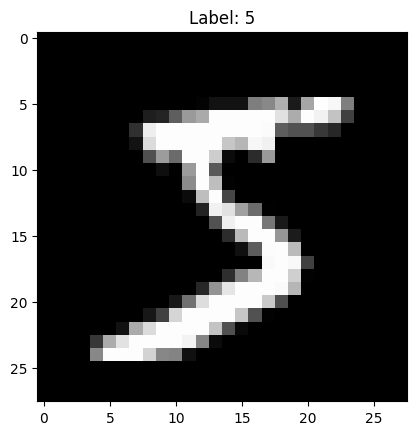

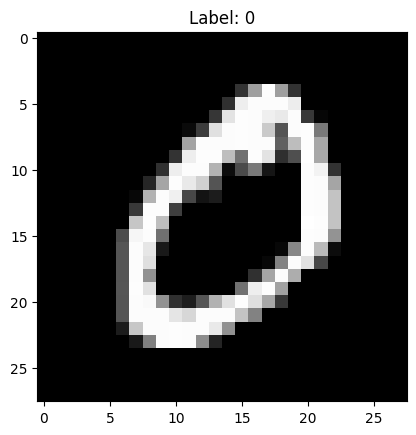

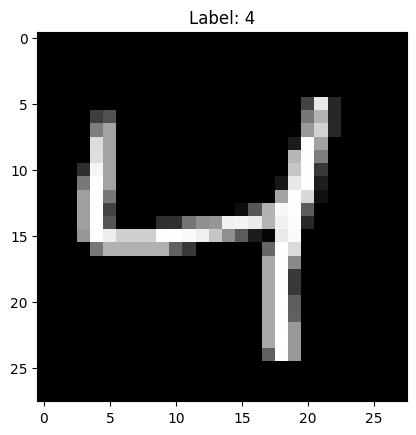

=== Raw Data Samples from the MNIST Test Dataset ===


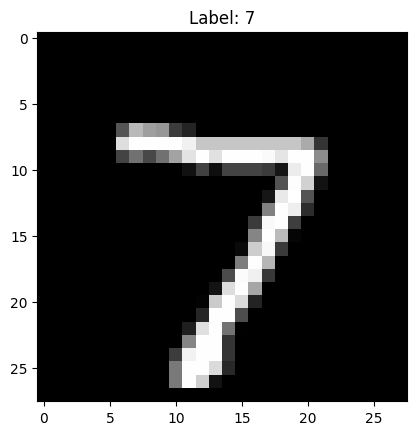

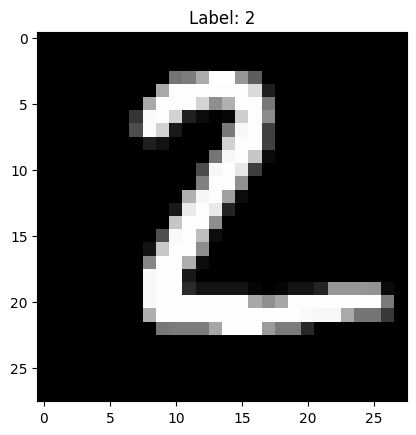

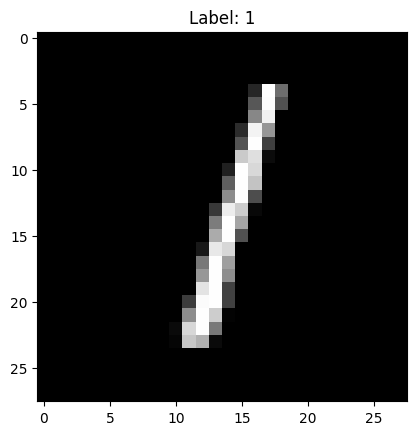

In [4]:
# Visualize the raw data from the dataset
print("=== Raw Data Samples from the MNIST Train Dataset ===")
for i in range(3):
    image, label = MNIST_train_dataset[i]
    image = image.squeeze().numpy()
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.show()

print("=== Raw Data Samples from the MNIST Test Dataset ===")
for i in range(3):
    image, label = MNIST_test_dataset[i]
    image = image.squeeze().numpy()
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.show()

**Helping Functions**

In [5]:
global train_start_time

def load_image(filename):
  im_pil = Image.open(filename)
  im = np.array(im_pil).astype(np.float32) / 255
  return im

def convert_to_list(input_list):
    if not isinstance(input_list, list):
        input_list = [input_list]
    return input_list

def plot_time_history(time_history_list=[], save=True, x_label_name="Epochs", y_label_name="Culminative Time Used", title_name="Time History"):
    time_history_list = convert_to_list(time_history_list)
    for i, time_history in enumerate(time_history_list):
        plt.plot(time_history, label=f"Time History {i+1}")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    if len(time_history_list) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_time_history_{train_start_time}.png')
    plt.show()

def plot_loss_history(train_loss_history_list=[], test_loss_history_list=[], save=True, x_label_name="Epochs", y_label_name="Loss", title_name="Loss History"):
    train_loss_history_list = convert_to_list(train_loss_history_list)
    test_loss_history_list = convert_to_list(test_loss_history_list)
    for i, train_loss_history in enumerate(train_loss_history_list):
        plt.plot(train_loss_history, label=f"Train Loss History {i+1}")
    for i, test_loss_history in enumerate(test_loss_history_list):
        plt.plot(test_loss_history, label=f"Test Loss History {i+1}")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    if (len(train_loss_history_list) + len(test_loss_history_list)) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_loss_history_{train_start_time}.png')
    plt.show()

def plot_accuracy_history(train_accuracy_history_list=[], test_accuracy_history_list=[], save=True, x_label_name="Epochs", y_label_name="Accuracy", title_name="Accuracy History"):
    train_accuracy_history_list = convert_to_list(train_accuracy_history_list)
    test_accuracy_history_list = convert_to_list(test_accuracy_history_list)
    for i, train_accuracy_history in enumerate(train_accuracy_history_list):
        plt.plot(train_accuracy_history, label=f"Train Accuracy History {i+1}")
    for i, test_accuracy_history in enumerate(test_accuracy_history_list):
        plt.plot(test_accuracy_history, label=f"Test Accuracy History {i+1}")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    if (len(train_accuracy_history_list) + len(test_accuracy_history_list)) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_accuracy_history_{train_start_time}.png')
    plt.show()

def plot_error_history(train_error_history_list=[], test_error_history_list=[], save=True, x_label_name="Epochs", y_label_name="Error", title_name="Error History"):
    train_error_history_list = convert_to_list(train_error_history_list)
    test_error_history_list = convert_to_list(test_error_history_list)
    for i, train_error_history in enumerate(train_error_history_list):
        plt.plot(train_error_history, label=f"Train Error History {i+1}")
    for i, test_error_history in enumerate(test_error_history_list):
        plt.plot(test_error_history, label=f"Test Error History {i+1}")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    if (len(train_error_history_list) + len(test_error_history_list)) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_error_history_{train_start_time}.png')
    plt.show()

def plot_time_history_single(time_history, save=True, x_label_name="Epochs", y_label_name="Culminative Time Used", title_name="Time History"):
    plt.plot(time_history, label=f"Time History")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_time_history_single_{train_start_time}.png')
    plt.show()

def plot_loss_history_single(train_loss_history, test_loss_history, save=True, x_label_name="Epochs", y_label_name="Loss", title_name="Loss History"):
    plt.plot(train_loss_history, label=f"Train Loss History")
    plt.plot(test_loss_history, label=f"Test Loss History")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_loss_history_single_{train_start_time}.png')
    plt.show()

def plot_accuracy_history_single(train_accuracy_history, test_accuracy_history, save=True, x_label_name="Epochs", y_label_name="Accuracy", title_name="Accuracy History"):
    plt.plot(train_accuracy_history, label=f"Train Accuracy History")
    plt.plot(test_accuracy_history, label=f"Test Accuracy History")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_accuracy_history_single_{train_start_time}.png')
    plt.show()

def plot_error_history_single(train_error_history, test_error_history, save=True, x_label_name="Epochs", y_label_name="Error", title_name="Error History"):
    plt.plot(train_error_history, label=f"Train Error History")
    plt.plot(test_error_history, label=f"Test Error History")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_error_history_single_{train_start_time}.png')
    plt.show()

def get_accuracy(outputs, labels):
    with torch.no_grad():
        if outputs.dim() > 1:
            _, predictions = torch.max(outputs, dim=1)
        else:
            predictions = outputs
        return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

def get_error(outputs, labels):
    with torch.no_grad():
        if outputs.dim() > 1:
            _, predictions = torch.max(outputs, dim=1)
        else:
            predictions = outputs
        return torch.tensor(torch.sum(predictions != labels).item() / len(predictions))
    
def image_accuracy(input_image, target_image):
    assert input_image.shape == target_image.shape
    input_image = input_image.byte()
    target_image = target_image.byte()
    num_different_pixels = torch.sum(input_image == target_image)
    total_pixels = target_image.numel()
    return torch.tensor(float(num_different_pixels) / total_pixels)

def image_error(input_image, target_image):
    assert input_image.shape == target_image.shape
    input_image = input_image.byte()
    target_image = target_image.byte()
    num_different_pixels = torch.sum(input_image != target_image)
    total_pixels = target_image.numel()
    return torch.tensor(float(num_different_pixels) / total_pixels)

## Section 1 Task 1 Neural Network Parameters

**Iterate Algorithms**

In [6]:
def evaluate_model_simple(model, dataloader, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error):
    losses = []
    accuracies = []
    errors = []
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = loss_func(outputs, labels)
            accuracy = accuracy_func(outputs, labels)
            error = error_func(outputs, labels)
            losses.append(loss)
            accuracies.append(accuracy)
            errors.append(error)
        loss_average = torch.stack(losses).mean().item()
        accuracy_average = torch.stack(accuracies).mean().item()
        error_average = torch.stack(errors).mean().item()
    return loss_average, accuracy_average, error_average

def iterate_model_simple(model, dataloader, num_epochs, optimizer, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error, show_history=True, test_dataloader=None, include_intial_history=False):
    loss_history = []
    accuracy_history = []
    error_history = []
    time_history = []
    start_time = timeit.default_timer()

    test_loss_history = []
    test_accuracy_history = []
    test_error_history = []

    if include_intial_history is True:
        loss, accuracy, error = evaluate_model_simple(model=model, dataloader=dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
        loss_history.append(loss)
        accuracy_history.append(accuracy)
        error_history.append(error)
        if test_dataloader is not None:
            test_loss, test_accuracy, test_error = evaluate_model_simple(model=model, dataloader=test_dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
            test_loss_history.append(test_loss)
            test_accuracy_history.append(test_accuracy)
            test_error_history.append(test_error)

    model.train()
    for epoch in range(num_epochs):
        losses = []
        accuracies = []
        errors = []
        for batch, (features, labels) in enumerate(dataloader):
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = loss_func(outputs, labels)
            accuracy = accuracy_func(outputs, labels)
            error = error_func(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss.detach()
            losses.append(loss)
            accuracies.append(accuracy)
            errors.append(error)
        time_used = timeit.default_timer() - start_time
        time_history.append(time_used)
        loss_average = torch.stack(losses).mean().item()
        accuracy_average = torch.stack(accuracies).mean().item()
        error_average = torch.stack(errors).mean().item()
        loss_history.append(loss_average)
        accuracy_history.append(accuracy_average)
        error_history.append(error_average)
        if test_dataloader is not None:
            test_loss, test_accuracy, test_error = evaluate_model_simple(model=model, dataloader=test_dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
            test_loss_history.append(test_loss)
            test_accuracy_history.append(test_accuracy)
            test_error_history.append(test_error)
        if show_history:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss_average:.16f}, Train Accuracy: {accuracy_average:.16f}, Train Error: {error_average:.16f}, Culminative Time Used: {time_used}')
            if test_dataloader is not None:
                print(f'Test Loss: {test_loss:.16f}, Test Accuracy: {test_accuracy:.16f}, Test Error: {test_error:.16f}')
    if test_dataloader is not None:
        return loss_history, accuracy_history, error_history, time_history, test_loss_history, test_accuracy_history, test_error_history
    return loss_history, accuracy_history, error_history, time_history

def train_neural_network_model(model, train_dataloader, test_dataloader, num_epochs, optimizer, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error, show_history=True, save_result=True, save_path_str="MNIST_CNN", save_file_extra_information=""):
    if test_dataloader is not None:
        train_loss_history, train_accuracy_history, train_error_history, time_history, test_loss_history, test_accuracy_history, test_error_history = iterate_model_simple(model, train_dataloader, num_epochs, optimizer, loss_func, accuracy_func, error_func, show_history, test_dataloader, True)
    else:
        train_loss_history, train_accuracy_history, train_error_history, time_history = iterate_model_simple(model, train_dataloader, num_epochs, optimizer, loss_func, accuracy_func, error_func, show_history)

    # Print learned parameters
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.data}')
    
    # Save Results
    if save_result:
        filename = "{}_{}_{}.npy".format(save_path_str, train_start_time, experiment_id)
        with open(filename, 'wb') as f:
            np.savez(f, time_history=time_history, train_loss_history=train_loss_history, train_accuracy_history=train_accuracy_history, train_error_history=train_error_history, test_loss_history=test_loss_history, test_accuracy_history=test_accuracy_history, test_error_history=test_error_history, extra_information=save_file_extra_information)
        torch.save(model.state_dict(), filename + "_model_state_dict.pth")
        logname = "{}_{}_{}.txt".format(save_path_str, train_start_time, experiment_id)
        with open(logname, 'wb') as f:
            f.write(save_file_extra_information.encode('utf-8'))

    # Graph
    if show_history:
        plot_time_history([time_history])
        plot_loss_history([train_loss_history], [test_loss_history])
        plot_accuracy_history([train_accuracy_history], [test_accuracy_history])
        plot_error_history([train_error_history], [test_error_history])
    
    return time_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history

def experiment_neural_network_model(train_dataset, test_dataset, modelClass, optimizerClass, train_func, epochs_list, learning_rate_list, batch_size_list, loss_func_list, accuracy_func_list, error_func_list, experiment_rounds = 1, show_history=True, save_result=True):
    global experiment_id
    experiment_id = 0

    epochs_list = convert_to_list(epochs_list)
    learning_rate_list = convert_to_list(learning_rate_list)
    batch_size_list = convert_to_list(batch_size_list)
    loss_func_list = convert_to_list(loss_func_list)
    accuracy_func_list = convert_to_list(accuracy_func_list)
    error_func_list = convert_to_list(error_func_list)

    time_history_total = []
    train_loss_history_total = []
    train_accuracy_history_total = []
    train_error_history_total = []
    test_loss_history_total = []
    test_accuracy_history_total = []
    test_error_history_total = []
    
    for n in range(experiment_rounds):
        experiment_id = experiment_id + 1
        print(f'=== Training Experiment {experiment_id} ===')
        print(f'number of epochs is {epochs_list[min(n, len(epochs_list) - 1)]}')
        num_epochs = epochs_list[min(n, len(epochs_list) - 1)]
        print(f'learning rate is {learning_rate_list[min(n, len(learning_rate_list) - 1)]}')
        learning_rate = learning_rate_list[min(n, len(learning_rate_list) - 1)]
        print(f'batch size is {batch_size_list[min(n, len(batch_size_list) - 1)]}')
        batch_size = batch_size_list[min(n, len(batch_size_list) - 1)]
        print(f'loss function is {loss_func_list[min(n, len(loss_func_list) - 1)]}')
        loss_func = loss_func_list[min(n, len(loss_func_list) - 1)]
        print(f'accuracy function is {accuracy_func_list[min(n, len(accuracy_func_list) - 1)]}')
        accuracy_func = accuracy_func_list[min(n, len(accuracy_func_list) - 1)]
        print(f'error function is {error_func_list[min(n, len(error_func_list) - 1)]}')
        error_func = error_func_list[min(n, len(error_func_list) - 1)]
        
        model = modelClass().to(device)

        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        optimizer = optimizerClass(model.parameters(), learning_rate)

        save_path_str = f"IERG4160_Project_{current_dataset_name}_E_{num_epochs}_lr_{learning_rate}_B_{batch_size}"

        global save_file_extra_information
        save_file_extra_information = f"""
        === {save_path_str} ===
        IERG4160 Project Training
        The experiment ID is: {experiment_id}
        The train start time is: {train_start_time}
        The dataset is: {current_dataset_name}

        experiment_rounds = {experiment_rounds}

        modelType = {modelClass.__name__}
        optimizerType = {optimizerClass.__name__}

        num_epochs_list = {epochs_list}
        learning_rate_list = {learning_rate_list}
        batch_size_list = {batch_size_list}
        loss_func_list = {loss_func_list}
        accuracy_func_list = {accuracy_func_list}
        error_func_list = {error_func_list}

        !-- Current Status --!
        num_epochs = {num_epochs}
        learning_rate = {learning_rate}
        batch_size = {batch_size}
        loss_func = {loss_func}
        accuracy_func = {accuracy_func}
        error_func = {error_func}
        """

        time_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history = train_func(model, train_dataloader, test_dataloader, num_epochs, optimizer, loss_func, accuracy_func, error_func, show_history, save_result, save_path_str, save_file_extra_information)

        time_history_total.append(time_history)
        train_loss_history_total.append(train_loss_history)
        train_accuracy_history_total.append(train_accuracy_history)
        train_error_history_total.append(train_error_history)
        test_loss_history_total.append(test_loss_history)
        test_accuracy_history_total.append(test_accuracy_history)
        test_error_history_total.append(test_error_history)
    
    print(f'=== The Experiment Result ===')
    print(f'Name of current dataset: {current_dataset_name}')
    plot_time_history(time_history_total)
    plot_loss_history(train_loss_history_total, test_loss_history_total)
    plot_accuracy_history(train_accuracy_history_total, test_accuracy_history_total)
    plot_error_history(train_error_history_total, test_error_history_total)


**Experiment**

In [7]:
# MNIST
# Load Dataset
train_dataset = MNIST_train_dataset
test_dataset = MNIST_test_dataset

# Show Dataset Status
current_dataset_name = "MNIST"
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

The current dataset is MNIST.
Number of samples in the train dataset: 60000
Number of samples in the test dataset: 10000


In [8]:
class MNIST_CNN_Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Flatten(),
            torch.nn.Linear(7*7*32, 10)
        )
    
    def forward(self, x):
        x = self.network(x)
        return x

The current dataset is MNIST.
The current train start time is 2024-04-19 22.35.31.
=== Training Experiment 1 ===
number of epochs is 10
learning rate is 0.03
batch size is 128
loss function is CrossEntropyLoss()
accuracy function is <function get_accuracy at 0x000002A2C8888720>
error function is <function get_error at 0x000002A2C88887C0>
Epoch [1/10], Train Loss: 0.6829861402511597, Train Accuracy: 0.7958811521530151, Train Error: 0.2041189074516296, Culminative Time Used: 44.67247539991513
Test Loss: 0.2698985636234283, Test Accuracy: 0.9185126423835754, Test Error: 0.0814873427152634
Epoch [2/10], Train Loss: 0.2226524055004120, Train Accuracy: 0.9346126317977905, Train Error: 0.0653873458504677, Culminative Time Used: 81.05890599999111
Test Loss: 0.1672108620405197, Test Accuracy: 0.9499604701995850, Test Error: 0.0500395558774471
Epoch [3/10], Train Loss: 0.1506469547748566, Train Accuracy: 0.9556292891502380, Train Error: 0.0443707779049873, Culminative Time Used: 120.706528499955

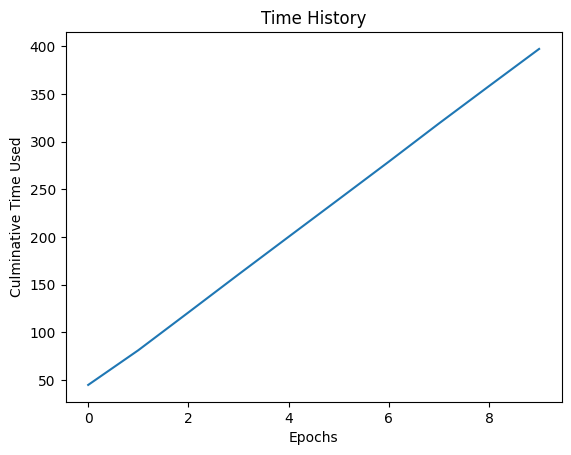

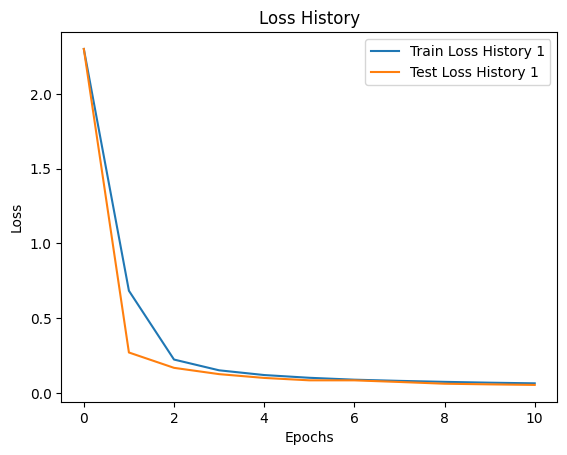

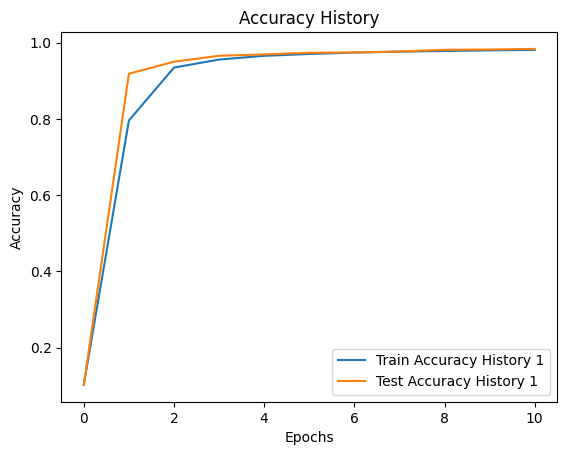

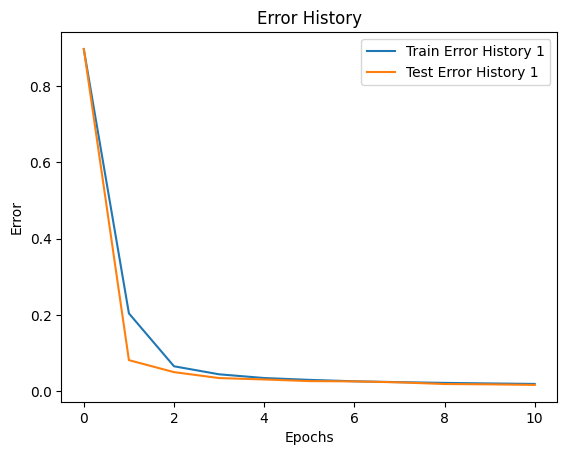

=== The Experiment Result ===
Name of current dataset: MNIST


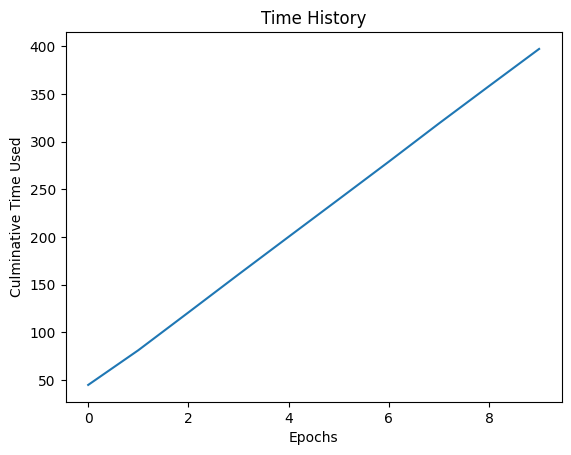

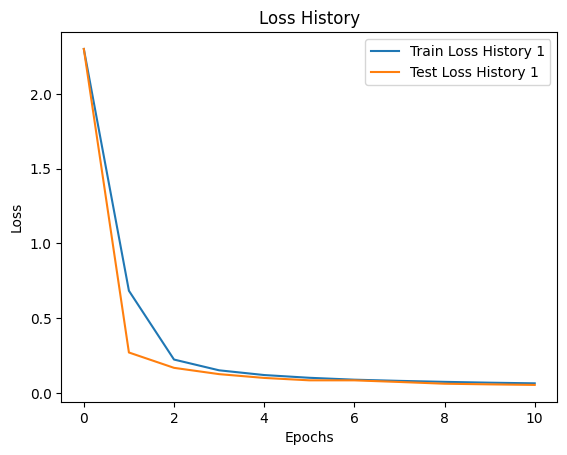

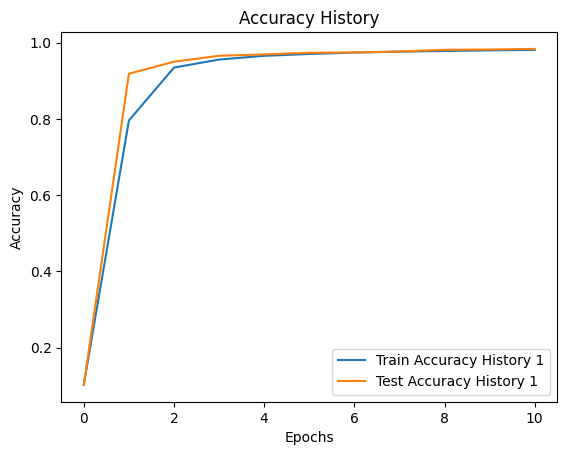

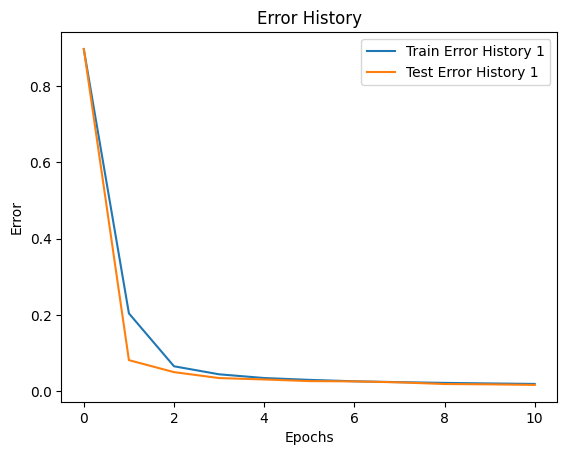

In [9]:
modelType = MNIST_CNN_Model
optimizerType = torch.optim.SGD
train_func = train_neural_network_model

num_epochs_list = 10
learning_rate_list = 0.03
batch_size_list = 128
loss_func_list = torch.nn.CrossEntropyLoss()
accuracy_func_list = get_accuracy
error_func_list = get_error

experiment_rounds = 1

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

experiment_neural_network_model(train_dataset, test_dataset, modelType, optimizerType, train_func, num_epochs_list, learning_rate_list, batch_size_list, loss_func_list, accuracy_func_list, error_func_list, experiment_rounds)

## Section 2 Task 2 U-Net

**MNIST Noisy Dataset**

Note: Remember in the noisy dataset label is a image, instead of a number in original dataset

In [10]:
#MNIST Noisy
noisy_sigma = 0.2

def add_gaussian_noise(images, sigma):
    noisy_images = images + sigma * np.random.normal(size=images.shape)
    noisy_images = np.clip(noisy_images, 0.0, 1.0)
    return (noisy_images * 255).astype(np.uint8)

def convert_pure_image_array(images):
    images = np.squeeze(images)
    images = images.reshape(images.shape[0], -1)
    return images

MNIST_train_dataset_noisy_image = []
MNIST_train_dataset_noisy_label = []
MNIST_test_dataset_noisy_image = []
MNIST_test_dataset_noisy_label = []
for image, _ in MNIST_train_dataset:
    noisy_images = add_gaussian_noise(image.numpy().astype(np.float32), noisy_sigma)
    noisy_images = convert_pure_image_array(noisy_images)
    truth_images = convert_pure_image_array((image.numpy() * 255).astype(np.uint8))
    MNIST_train_dataset_noisy_image.append(noisy_images)
    MNIST_train_dataset_noisy_label.append(truth_images)
for image, _ in MNIST_test_dataset:
    noisy_images = add_gaussian_noise(image.numpy().astype(np.float32), noisy_sigma)
    noisy_images = convert_pure_image_array(noisy_images)
    truth_images = convert_pure_image_array((image.numpy() * 255).astype(np.uint8))
    MNIST_test_dataset_noisy_image.append(noisy_images)
    MNIST_test_dataset_noisy_label.append(truth_images)

In [11]:
class MNISTNoisy(Dataset):
    def __init__(self, data_sample, targets_sample, train=True, transform=None, target_transform=None):
        self.train = train
        self.data, self.targets = self._load_data(data_sample, targets_sample)
        self.transform = transform
        self.target_transform = target_transform

    def _load_data(self, data_sample, targets_sample):
        data = torch.tensor(data_sample)
        targets = torch.tensor(targets_sample)
        return data, targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        img = Image.fromarray(img.numpy(), mode="L")
        target = Image.fromarray(target.numpy(), mode="L")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

MNIST_train_dataset_noisy = MNISTNoisy(MNIST_train_dataset_noisy_image, MNIST_train_dataset_noisy_label, train=True, transform=transforms.ToTensor(), target_transform=transforms.ToTensor())
MNIST_test_dataset_noisy = MNISTNoisy(MNIST_test_dataset_noisy_image, MNIST_test_dataset_noisy_label, train=False, transform=transforms.ToTensor(), target_transform=transforms.ToTensor())

# Load Dataset
train_dataset = MNIST_train_dataset_noisy
test_dataset = MNIST_test_dataset_noisy

# Show Dataset Status
current_dataset_name = "MNIST Noisy"
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

C:\Users\chris\AppData\Local\Temp\ipykernel_12204\1239762066.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  data = torch.tensor(data_sample)


The current dataset is MNIST Noisy.
Number of samples in the train dataset: 60000
Number of samples in the test dataset: 10000


=== Raw Data Samples from the MNIST Noisy Train Dataset ===
Noisy Image:


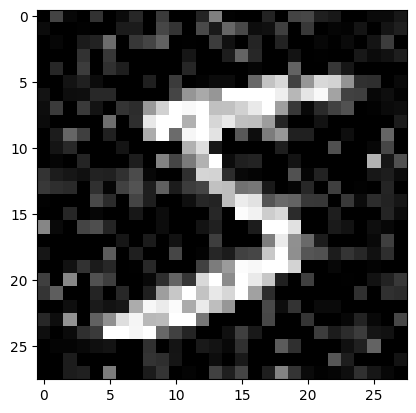

Ground Truth Image:


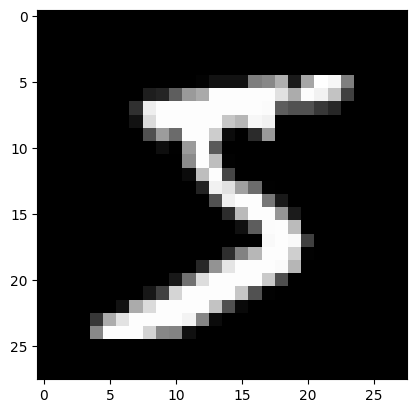

Noisy Image:


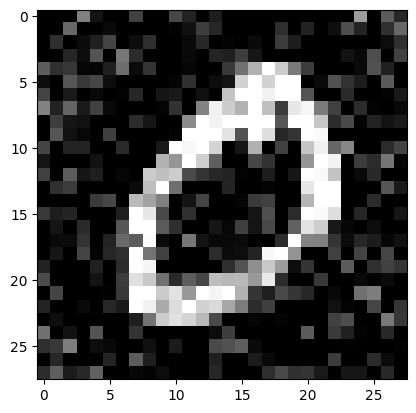

Ground Truth Image:


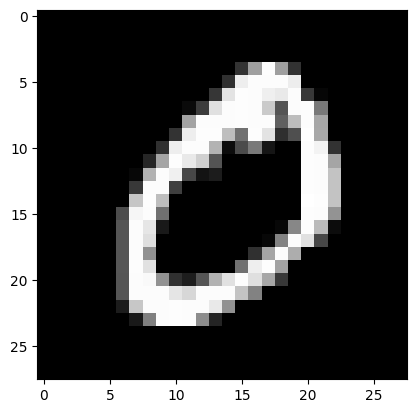

Noisy Image:


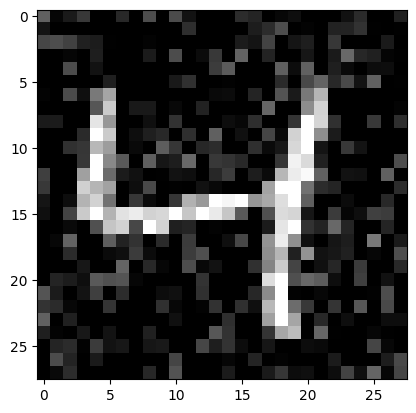

Ground Truth Image:


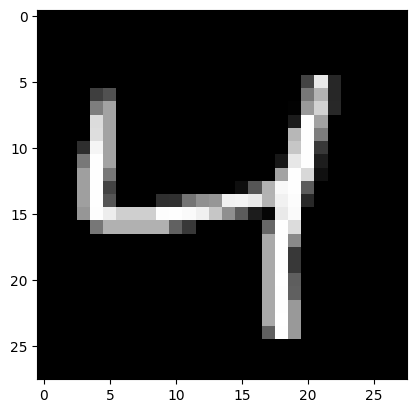

=== Raw Data Samples from the MNIST Noisy Test Dataset ===
Noisy Image:


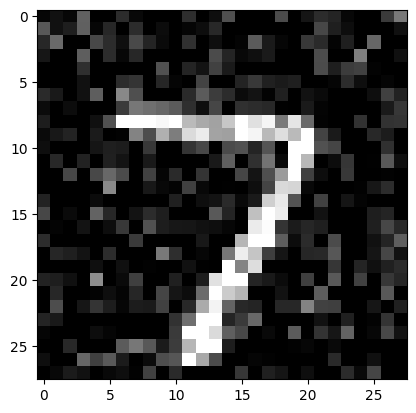

Ground Truth Image:


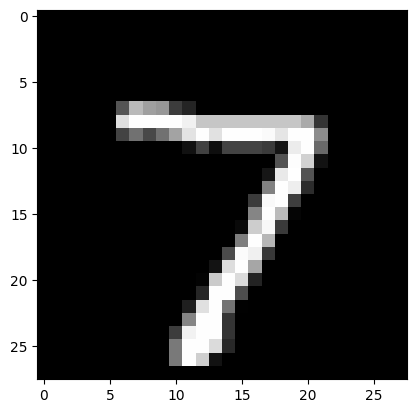

Noisy Image:


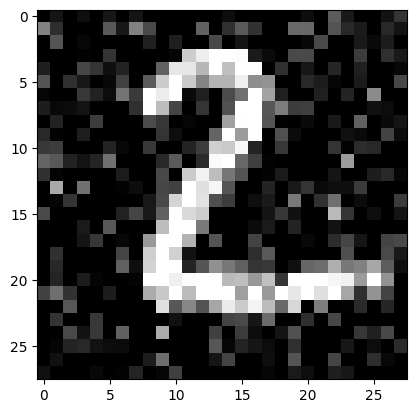

Ground Truth Image:


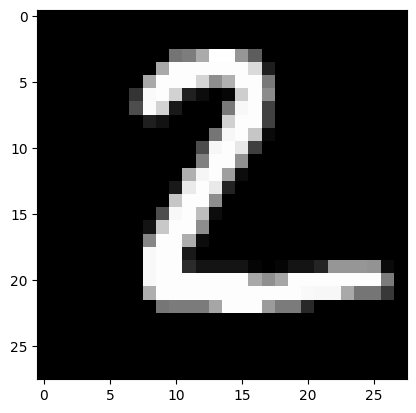

Noisy Image:


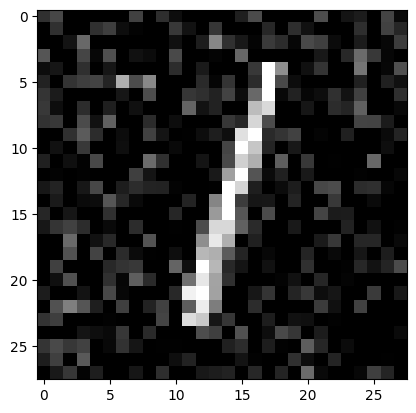

Ground Truth Image:


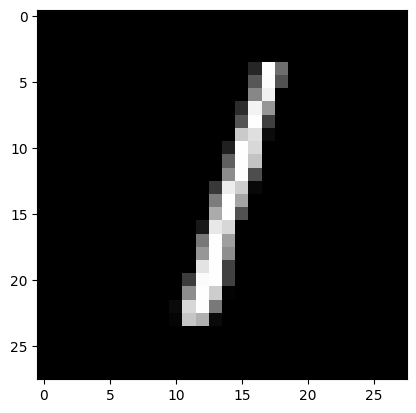

In [12]:
# Visualize the raw data from the dataset
print("=== Raw Data Samples from the MNIST Noisy Train Dataset ===")
for i in range(3):
    image, label = MNIST_train_dataset_noisy[i]
    print("Noisy Image:")
    image = image.numpy().squeeze()
    plt.imshow(image, cmap='gray')
    plt.show()
    print("Ground Truth Image:")
    label = label.numpy().squeeze()
    plt.imshow(label, cmap='gray')
    plt.show()

print("=== Raw Data Samples from the MNIST Noisy Test Dataset ===")
for i in range(3):
    image, label = MNIST_test_dataset_noisy[i]
    print("Noisy Image:")
    image = image.numpy().squeeze()
    plt.imshow(image, cmap='gray')
    plt.show()
    print("Ground Truth Image:")
    label = label.numpy().squeeze()
    plt.imshow(label, cmap='gray')
    plt.show()

**Experiment**

In [13]:
class MNIST_UNet_Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.up1 = torch.nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.up2 = torch.nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
        self.conv5 = torch.nn.Conv2d(48, 32, kernel_size=3, padding=1)
        self.conv6 = torch.nn.Conv2d(32, 1, kernel_size=1)
        self.relu1 = torch.nn.ReLU()
        
    def forward(self, x):
        conv1_out = self.conv1(x)
        pool1_out = self.pool1(conv1_out)
        conv2_out = self.conv2(pool1_out)
        pool2_out = self.pool2(conv2_out)
        conv3_out = self.conv3(pool2_out)
        up1_out = self.up1(conv3_out)
        cat1_out = torch.cat([up1_out, conv2_out], dim=1)
        conv4_out = self.conv4(cat1_out)
        up2_out = self.up2(conv4_out)
        cat2_out = torch.cat([up2_out, conv1_out], dim=1)
        conv5_out = self.conv5(cat2_out)
        conv6_out = self.conv6(conv5_out)
        relu1_out = self.relu1(conv6_out)
        return relu1_out
    
class MNIST_UNet_Model_SingleChannel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.up1 = torch.nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.up2 = torch.nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2)
        self.conv5 = torch.nn.Conv2d(24, 16, kernel_size=3, padding=1)
        self.conv6 = torch.nn.Conv2d(16, 1, kernel_size=1)
        self.relu1 = torch.nn.ReLU()

    def forward(self, x):
        conv1_out = self.conv1(x)
        pool1_out = self.pool1(conv1_out)
        conv2_out = self.conv2(pool1_out)
        pool2_out = self.pool2(conv2_out)
        conv3_out = self.conv3(pool2_out)
        up1_out = self.up1(conv3_out)
        cat1_out = torch.cat([up1_out, conv2_out], dim=1)
        conv4_out = self.conv4(cat1_out)
        up2_out = self.up2(conv4_out)
        cat2_out = torch.cat([up2_out, conv1_out], dim=1)
        conv5_out = self.conv5(cat2_out)
        conv6_out = self.conv6(conv5_out)
        relu1_out = self.relu1(conv6_out)
        return relu1_out

The current dataset is MNIST Noisy.
The current train start time is 2024-04-19 22.42.55.
=== Training Experiment 1 ===
number of epochs is 10
learning rate is 0.1
batch size is 64
loss function is MSELoss()
accuracy function is <function image_accuracy at 0x000002A2C88885E0>
error function is <function image_error at 0x000002A2C8889580>
Epoch [1/10], Train Loss: 0.1120071560144424, Train Accuracy: 0.9933188557624817, Train Error: 0.0066810669377446, Culminative Time Used: 88.85255189996678
Test Loss: 0.1141074821352959, Test Accuracy: 0.9926722049713135, Test Error: 0.0073278369382024
Epoch [2/10], Train Loss: 0.1120029389858246, Train Accuracy: 0.9933215379714966, Train Error: 0.0066785593517125, Culminative Time Used: 147.32545529992785
Test Loss: 0.1141074448823929, Test Accuracy: 0.9926722049713135, Test Error: 0.0073278369382024
Epoch [3/10], Train Loss: 0.1119995638728142, Train Accuracy: 0.9933203458786011, Train Error: 0.0066796219907701, Culminative Time Used: 206.244435300002

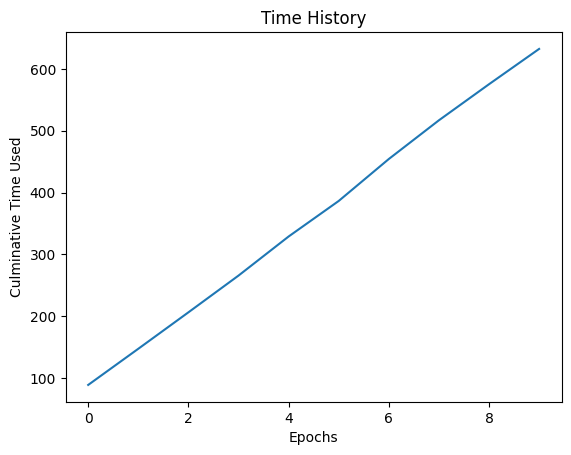

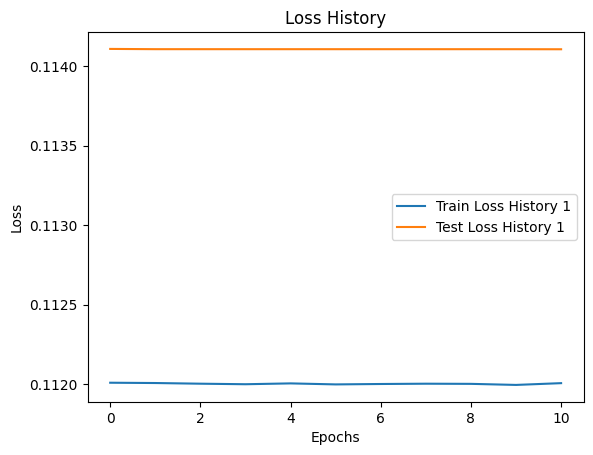

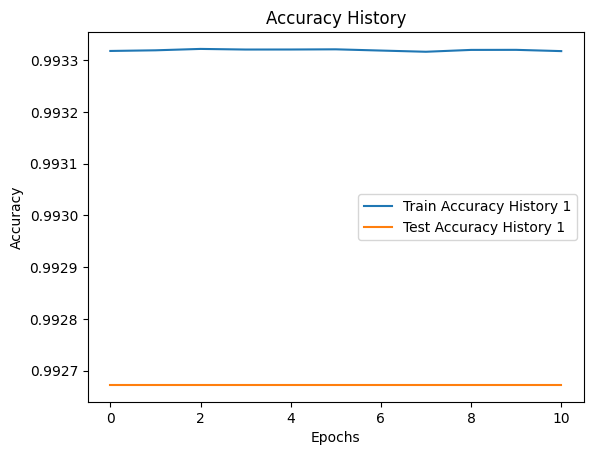

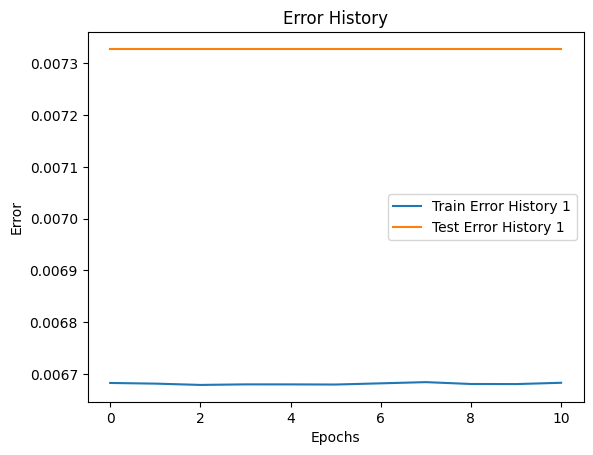

=== The Experiment Result ===
Name of current dataset: MNIST Noisy


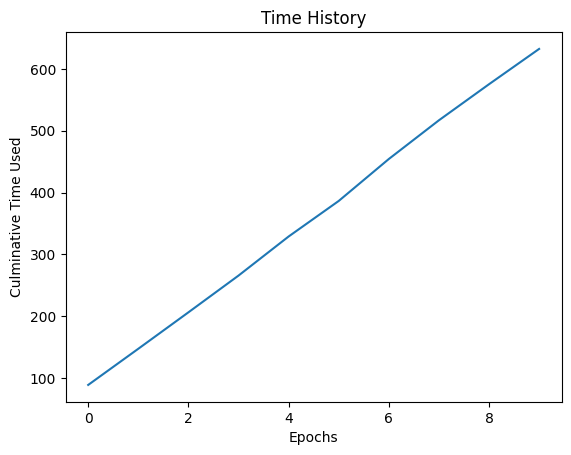

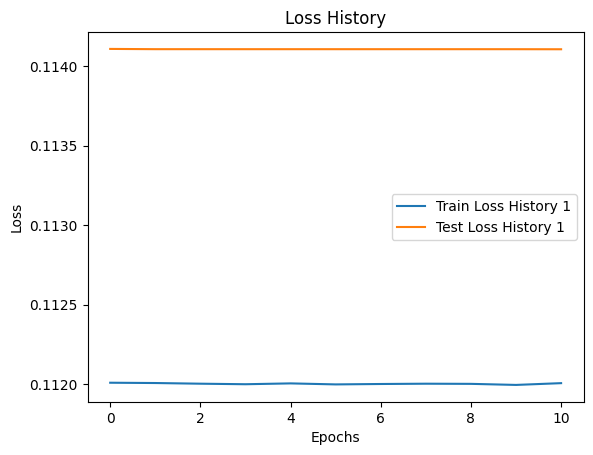

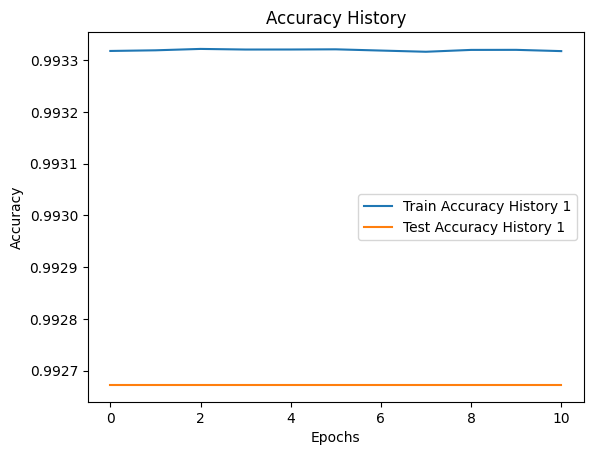

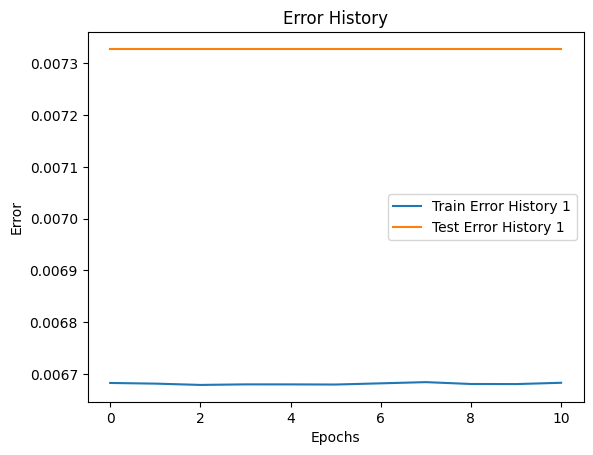

In [14]:
modelType = MNIST_UNet_Model_SingleChannel
optimizerType = torch.optim.SGD
train_func = train_neural_network_model

num_epochs_list = 10
learning_rate_list = 0.1
batch_size_list = 64
loss_func_list = torch.nn.MSELoss()
accuracy_func_list = image_accuracy
error_func_list = image_error

experiment_rounds = 1

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

experiment_neural_network_model(train_dataset, test_dataset, modelType, optimizerType, train_func, num_epochs_list, learning_rate_list, batch_size_list, loss_func_list, accuracy_func_list, error_func_list, experiment_rounds)

The current dataset is MNIST Noisy.
The current train start time is 2024-04-19 22.53.35.
=== Training Experiment 1 ===
number of epochs is 10
learning rate is 0.1
batch size is 64
loss function is MSELoss()
accuracy function is <function image_accuracy at 0x000002A2C88885E0>
error function is <function image_error at 0x000002A2C8889580>
Epoch [1/10], Train Loss: 0.0026565201114863, Train Accuracy: 0.9918789267539978, Train Error: 0.0081210592761636, Culminative Time Used: 114.53985499998089
Test Loss: 0.0013623537961394, Test Accuracy: 0.9908140301704407, Test Error: 0.0091859856620431
Epoch [2/10], Train Loss: 0.0013477591564879, Train Accuracy: 0.9915322661399841, Train Error: 0.0084677496924996, Culminative Time Used: 181.7650202999357
Test Loss: 0.0013209229800850, Test Accuracy: 0.9906402230262756, Test Error: 0.0093597602099180
Epoch [3/10], Train Loss: 0.0013217913219705, Train Accuracy: 0.9917444586753845, Train Error: 0.0082555580884218, Culminative Time Used: 249.865702099981

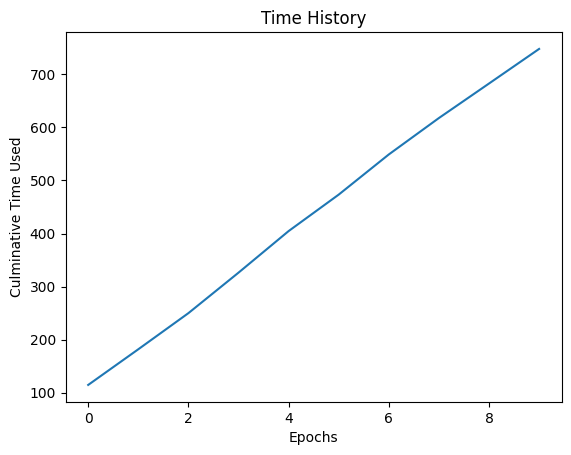

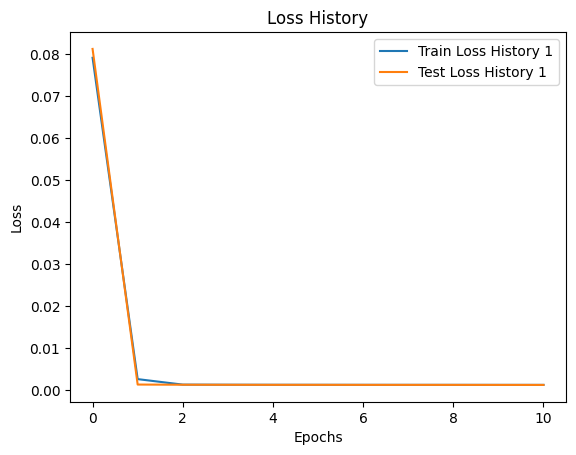

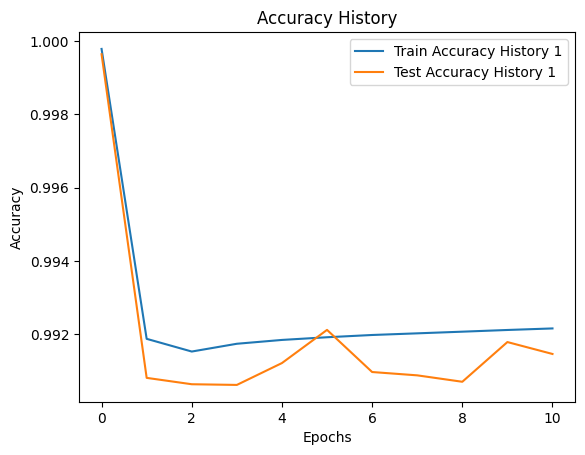

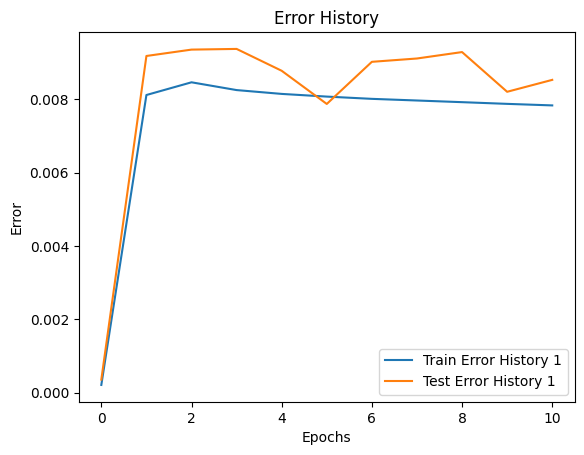

=== The Experiment Result ===
Name of current dataset: MNIST Noisy


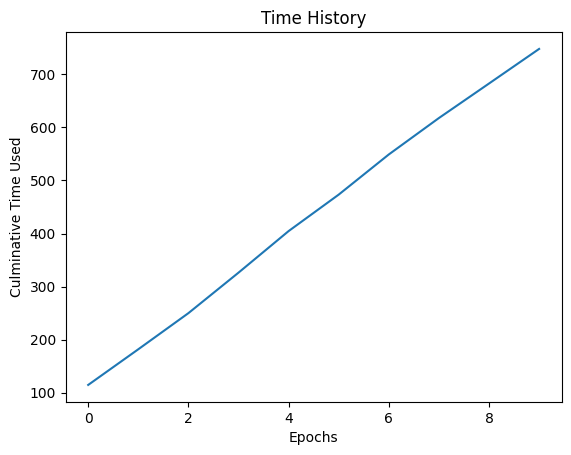

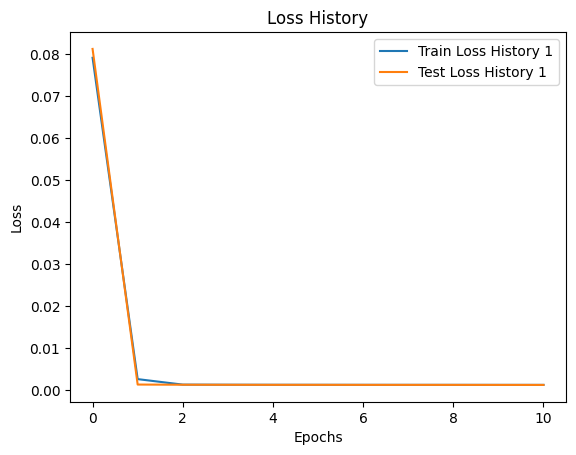

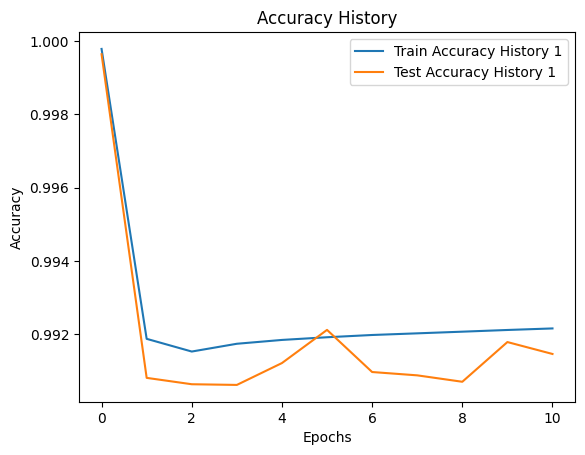

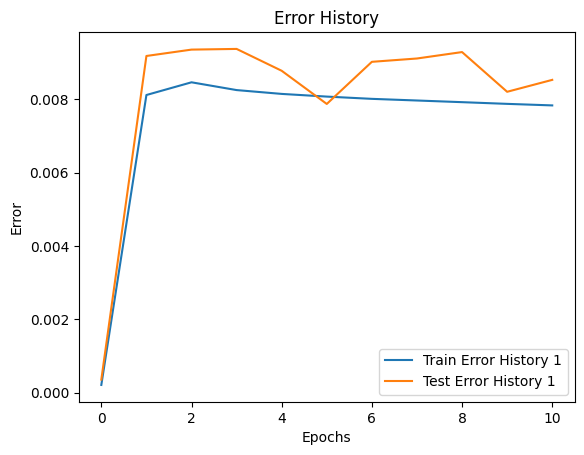

In [15]:
modelType = MNIST_UNet_Model
optimizerType = torch.optim.SGD
train_func = train_neural_network_model

# Custom Parameters
custom_image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((16,16)),
    transforms.ToTensor()
])

custom_target_transform = transforms.Compose([
    transforms.Resize((16,16)),
    transforms.ToTensor()
])

train_dataset.transform = custom_image_transform
train_dataset.target_transform = custom_target_transform
test_dataset.transform = custom_image_transform
test_dataset.target_transform = custom_target_transform
#---------------------#

num_epochs_list = 10
learning_rate_list = 0.1
batch_size_list = 64
loss_func_list = torch.nn.MSELoss()
accuracy_func_list = image_accuracy
error_func_list = image_error

experiment_rounds = 1

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

experiment_neural_network_model(train_dataset, test_dataset, modelType, optimizerType, train_func, num_epochs_list, learning_rate_list, batch_size_list, loss_func_list, accuracy_func_list, error_func_list, experiment_rounds)

## Section 3 Analysis

### Section 3.1 Model Prediction

**Image Prediction**

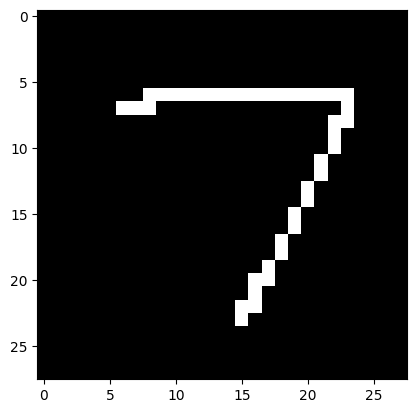

The chances for predicted labels are:  [ 0.4828499 -5.382873   4.8984075  2.4162338 -6.272201  -1.4720715
 -8.133187  11.009876   0.7299226  3.6914945]
The predicted label is:  7


In [16]:
# --- Change the parameter manually here!! --- #
predict_image_path = "PredictLabelTest.png"
predict_model_path = "IERG4160_Project_MNIST_E_10_lr_0.1_B_64_2024-04-17 12.12.01_2.npy_model_state_dict.pth"
predict_model_type = MNIST_CNN_Model
predict_image_togrey = True
#----------------------------------------------#

predict_model = predict_model_type()
predict_model.load_state_dict(torch.load(predict_model_path, map_location=device))

if predict_image_togrey is True:
    predict_image = 1.0 - cv2.cvtColor(cv2.resize(load_image(predict_image_path), (28, 28)), cv2.COLOR_RGB2GRAY)
else:
    predict_image = cv2.resize(load_image(predict_image_path), (28, 28))
plt.imshow(predict_image, cmap='gray')
plt.show()

predict_image_torch = torch.Tensor(predict_image[np.newaxis, np.newaxis])
predict_predicted_label_array = predict_model(predict_image_torch).detach().numpy()[0, ...]
print('The chances for predicted labels are: ', predict_predicted_label_array)

predict_predicted_label = np.argmax(predict_predicted_label_array)

print('The predicted label is: ', predict_predicted_label)

**Noisy Image to Clean Image**

In [ ]:
# --- Change the parameter manually here!! --- #
to_clean_image_path = "NoisyImageTest.png"
to_clean_model_path = "IERG4160_Project_MNIST Noisy_E_10_lr_0.1_B_64_2024-04-18 22.13.20_1.npy_model_state_dict.pth"
to_clean_model_type = MNIST_UNet_Model_SingleChannel

to_clean_image_transform = transforms.Compose([
    #transforms.Resize((16,16)),
    #transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])
#----------------------------------------------#

to_clean_model = to_clean_model_type()
to_clean_model.load_state_dict(torch.load(to_clean_model_path, map_location=device))

to_clean_image = Image.open(to_clean_image_path)

to_clean_image_transformed = to_clean_image_transform(to_clean_image)
to_clean_image = to_clean_image_transformed.numpy()

to_clean_image_torch = torch.Tensor(to_clean_image[np.newaxis])
clean_image = to_clean_model(to_clean_image_torch).detach().numpy()[0, ...]

print("=== Input: Noisy Image ===")
plt.imshow(to_clean_image.transpose(1, 2, 0).squeeze(), cmap='gray')
plt.show()

print("=== Output: Clean Image ===")
plt.imshow(clean_image.transpose(1, 2, 0).squeeze(), cmap='gray')
plt.show()

**Noisy Image to Clean Image with testing data**

=== Input: Noisy Image ===


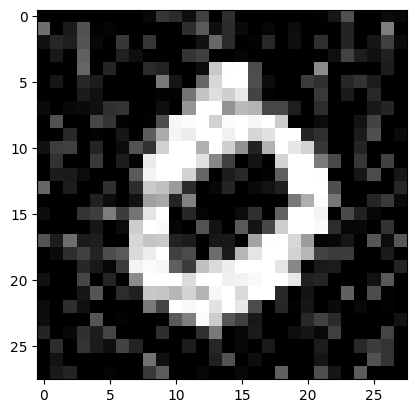

=== Output: Clean Image ===


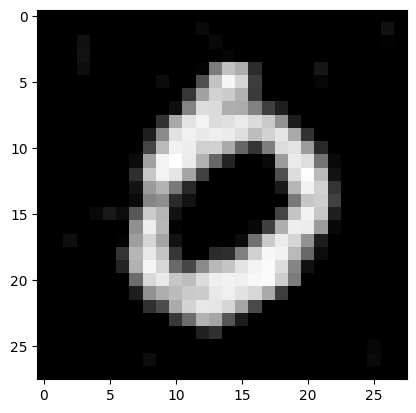

In [24]:
# --- Change the parameter manually here!! --- #
to_clean_model_path = "IERG4160_Project_MNIST Noisy_E_10_lr_0.1_B_64_2024-04-18 22.13.20_1.npy_model_state_dict.pth"
to_clean_model_type = MNIST_UNet_Model_SingleChannel

to_clean_image_transform = transforms.Compose([
    #transforms.Resize((16,16)),
    #transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])
#----------------------------------------------#

to_clean_model = to_clean_model_type()
to_clean_model.load_state_dict(torch.load(to_clean_model_path, map_location=device))

to_clean_image = Image.fromarray(MNIST_test_dataset_noisy_image[3], mode="L")

to_clean_image_transformed = to_clean_image_transform(to_clean_image)
to_clean_image = to_clean_image_transformed.numpy()

to_clean_image_torch = torch.Tensor(to_clean_image[np.newaxis])
clean_image = to_clean_model(to_clean_image_torch).detach().numpy()[0, ...]

print("=== Input: Noisy Image ===")
plt.imshow(to_clean_image.transpose(1, 2, 0).squeeze(), cmap='gray')
plt.show()

print("=== Output: Clean Image ===")
plt.imshow(clean_image.transpose(1, 2, 0).squeeze(), cmap='gray')
plt.show()

### Section 3.2 Training Performance Visulization

**Clear and Initialize Data**

In [27]:
data_time_history_total = []
data_train_loss_history_total = []
data_train_accuracy_history_total = []
data_train_error_history_total = []
data_test_loss_history_total = []
data_test_accuracy_history_total = []
data_test_error_history_total = []
# Run this whenever you want to clear all appended data or initially load data!!

**Loading Data Manually**

*** Loading file...                     ***
Result has been loaded from the file:  IERG4160_Project_MNIST_E_10_lr_0.1_B_64_2024-04-17 12.12.01_2.npy
=======Content of the File=======
['time_history', 'train_loss_history', 'train_accuracy_history', 'train_error_history', 'test_loss_history', 'test_accuracy_history', 'test_error_history', 'extra_information']
=======STATUS RESULT=======
Time History:  [ 30.9273875  50.8618095  70.1191716  89.2767739 108.7830754 127.8473514
 146.9426857 166.2599746 185.8299711 204.9513066]
=======TRAIN RESULT=======
Train Loss History:  [2.30327892 0.23897694 0.07840613 0.05963869 0.04989075 0.04319962
 0.03732558 0.03388122 0.03037063 0.02839055 0.02545174]
Train Accuracy History:  [0.09941365 0.92643923 0.97699559 0.98159313 0.98489141 0.98704022
 0.988756   0.98968881 0.99085486 0.99117136 0.99227077]
Train Error History:  [0.90058637 0.07356077 0.0230044  0.01840685 0.01510861 0.01295976
 0.011244   0.01031117 0.00914512 0.00882863 0.00772921]
=======

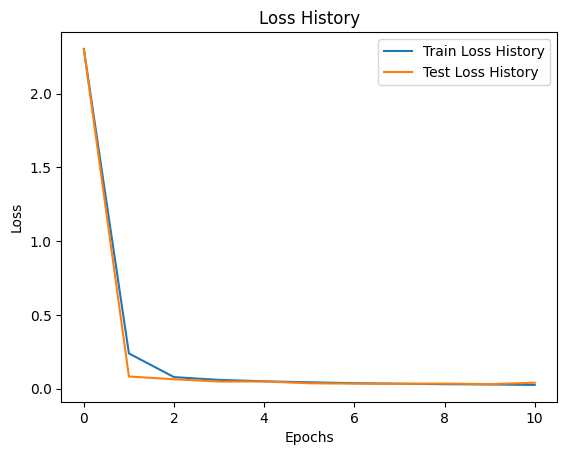

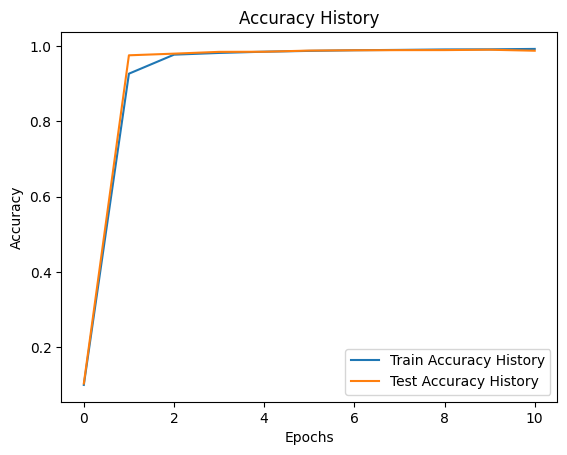

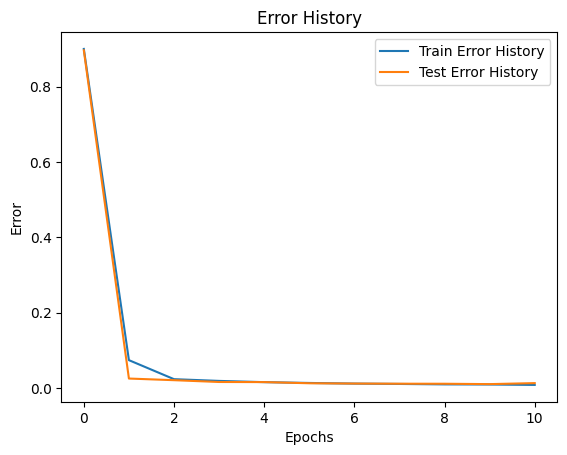

In [28]:
# --- Change the parameter manually here!! --- #
filename_load_list = ["IERG4160_Project_MNIST_E_10_lr_0.1_B_64_2024-04-17 12.12.01_2.npy"]
data_append_load = True
#----------------------------------------------#

for filename_load in filename_load_list:
    print("============================================")
    print("*** Loading file...                     ***")
    print("============================================")
    try:
        # Load the file
        load_result = np.load(filename_load)
        print('Result has been loaded from the file: ', filename_load)

        # Load the attributes from the file
        data_time_history = load_result['time_history']
        data_train_loss_history = load_result['train_loss_history']
        data_train_accuracy_history = load_result['train_accuracy_history']
        data_train_error_history = load_result['train_error_history']
        data_test_loss_history = load_result['test_loss_history']
        data_test_accuracy_history = load_result['test_accuracy_history']
        data_test_error_history = load_result['test_error_history']

        print("=======Content of the File=======")
        print(load_result.files)

        print("=======STATUS RESULT=======")
        print("Time History: ", data_time_history)

        print("=======TRAIN RESULT=======")
        print("Train Loss History: ", data_train_loss_history)
        print("Train Accuracy History: ", data_train_accuracy_history)
        print("Train Error History: ", data_train_error_history)

        print("=======TEST RESULT=======")
        print("Test Loss History: ", data_test_loss_history)
        print("Test Accuracy History: ", data_test_accuracy_history)
        print("Test Error History: ", data_test_error_history)

        print("=======VISUALIZATION RESULT=======")
        #plot_time_history_single(data_time_history, save=False)
        plot_loss_history_single(data_train_loss_history, data_test_loss_history, save=False)
        plot_accuracy_history_single(data_train_accuracy_history, data_test_accuracy_history, save=False)
        plot_error_history_single(data_train_error_history, data_test_error_history, save=False)

        # Append the data
        if data_append_load:
            data_time_history_total.append(data_time_history)
            data_train_loss_history_total.append(data_train_loss_history)
            data_train_accuracy_history_total.append(data_train_accuracy_history)
            data_train_error_history_total.append(data_train_error_history)
            data_test_loss_history_total.append(data_test_loss_history)
            data_test_accuracy_history_total.append(data_test_accuracy_history)
            data_test_error_history_total.append(data_test_error_history)
    except (FileNotFoundError, IOError):
        print("Failed to load the file: ", filename_load)
    print("")

**Plot for Experiment Parameters**

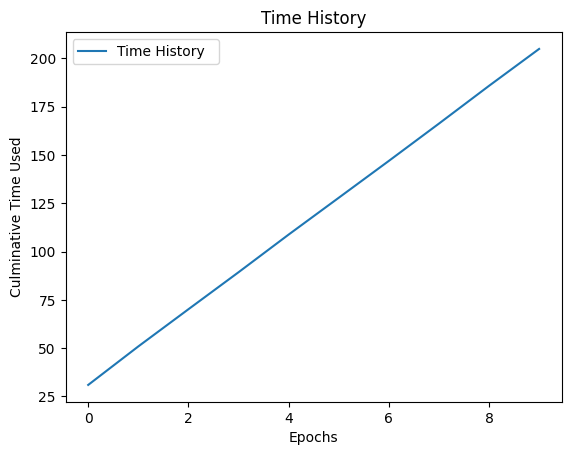

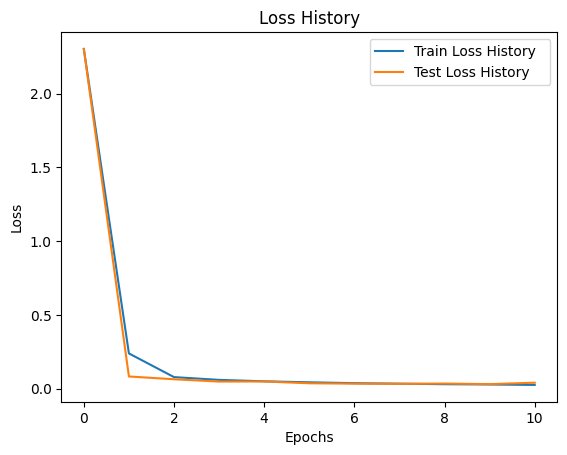

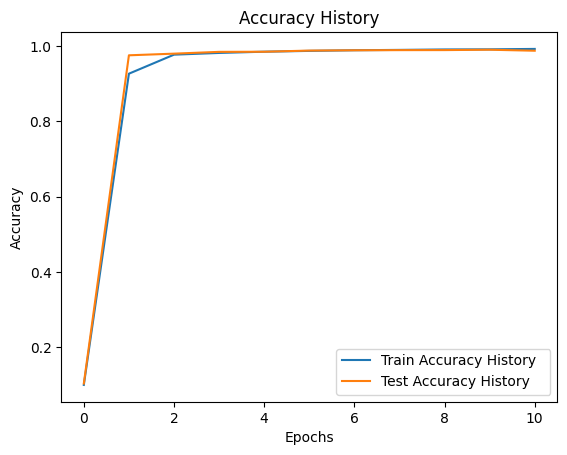

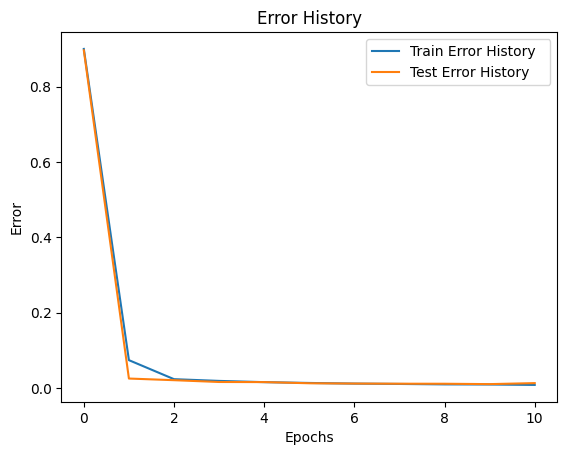

In [29]:
# --- Change the parameter manually here!! --- #
plot_parameters_list = [""]
plot_title_strings = ""
plot_legend_strings = ""
plot_save_fig_bool = False
plot_show_train_bool = True
plot_show_test_bool = True
plot_log_scale = False
#----------------------------------------------#

plot_different_parameter_time_history = convert_to_list(data_time_history_total)
for i, plot_time_history in enumerate(plot_different_parameter_time_history):
    plt.plot(plot_time_history, label=f"Time History {plot_legend_strings} {plot_parameters_list[i]}")
plt.xlabel("Epochs")
if plot_log_scale is True:
    plt.ylabel("Log Culminative Time Used")
    plt.yscale('log')
else:
    plt.ylabel("Culminative Time Used")
plt.title("Time History" + plot_title_strings)
plt.legend()
if plot_save_fig_bool is True:
    plt.savefig(f'Analysis_{current_dataset_name}_time_history_{plot_legend_strings}_{train_start_time}.png')
plt.show()

plot_different_parameter_train_loss_history = convert_to_list(data_train_loss_history_total)
plot_different_parameter_test_loss_history = convert_to_list(data_test_loss_history_total)
if plot_show_train_bool is True:
    for i, plot_train_loss_history in enumerate(plot_different_parameter_train_loss_history):
        plt.plot(plot_train_loss_history, label=f"Train Loss History {plot_legend_strings} {plot_parameters_list[i]}")
if plot_show_test_bool is True:
    for i, plot_test_loss_history in enumerate(plot_different_parameter_test_loss_history):
        plt.plot(plot_test_loss_history, label=f"Test Loss History {plot_legend_strings} {plot_parameters_list[i]}")
plt.xlabel("Epochs")
if plot_log_scale is True:
    plt.ylabel("Log Loss")
    plt.yscale('log')
else:
    plt.ylabel("Loss")
plt.title("Loss History" + plot_title_strings)
plt.legend()
if plot_save_fig_bool is True:
    plt.savefig(f'Analysis_{current_dataset_name}_loss_history__{plot_legend_strings}_{train_start_time}.png')
plt.show()

plot_different_parameter_train_accuracy_history = convert_to_list(data_train_accuracy_history_total)
plot_different_parameter_test_accuracy_history = convert_to_list(data_test_accuracy_history_total)
if plot_show_train_bool is True:
    for i, plot_train_accuracy_history in enumerate(plot_different_parameter_train_accuracy_history):
        plt.plot(plot_train_accuracy_history, label=f"Train Accuracy History {plot_legend_strings} {plot_parameters_list[i]}")
if plot_show_test_bool is True:
    for i, plot_test_accuracy_history in enumerate(plot_different_parameter_test_accuracy_history):
        plt.plot(plot_test_accuracy_history, label=f"Test Accuracy History {plot_legend_strings} {plot_parameters_list[i]}")
plt.xlabel("Epochs")
if plot_log_scale is True:
    plt.ylabel("Log Accuracy")
    plt.yscale('log')
else:
    plt.ylabel("Accuracy")
plt.title("Accuracy History" + plot_title_strings)
plt.legend()
if plot_save_fig_bool is True:
    plt.savefig(f'Analysis_{current_dataset_name}_accuracy_history__{plot_legend_strings}_{train_start_time}.png')
plt.show()

plot_different_parameter_train_error_history = convert_to_list(data_train_error_history_total)
plot_different_parameter_test_error_history = convert_to_list(data_test_error_history_total)
if plot_show_train_bool is True:
    for i, plot_train_error_history in enumerate(plot_different_parameter_train_error_history):
        plt.plot(plot_train_error_history, label=f"Train Error History {plot_legend_strings} {plot_parameters_list[i]}")
if plot_show_test_bool is True:
    for i, plot_test_error_history in enumerate(plot_different_parameter_test_error_history):
        plt.plot(plot_test_error_history, label=f"Test Error History {plot_legend_strings} {plot_parameters_list[i]}")
plt.xlabel("Epochs")
if plot_log_scale is True:
    plt.ylabel("Log Error")
    plt.yscale('log')
else:
    plt.ylabel("Error")
plt.title("Error History" + plot_title_strings)
plt.legend()
if plot_save_fig_bool is True:
    plt.savefig(f'Analysis_{current_dataset_name}_error_history__{plot_legend_strings}_{train_start_time}.png')
plt.show()

**Plot for Batchsize-Accuracy curve.**

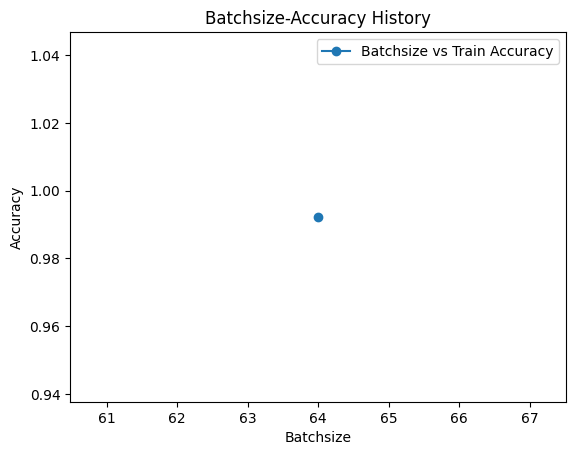

In [30]:
plot_batchsize_list = [64]
plot_save_fig_bool = False
plot_show_train_bool = True
plot_show_test_bool = False
plot_log_scale = False

plot_different_parameter_train_accuracy_history = convert_to_list(data_train_accuracy_history_total)
plot_different_parameter_test_accuracy_history = convert_to_list(data_test_accuracy_history_total)
plot_batchsize_accuracy_point_train = []
plot_batchsize_accuracy_point_test = []
if plot_show_train_bool is True:
    for plot_train_accuracy_history in plot_different_parameter_train_accuracy_history:
        plot_batchsize_accuracy_point_train.append(plot_train_accuracy_history[-1])
    plt.plot(plot_batchsize_list, plot_batchsize_accuracy_point_train, marker='o', linestyle='-', label=f"Batchsize vs Train Accuracy")
if plot_show_test_bool is True:
    for plot_test_accuracy_history in plot_different_parameter_test_accuracy_history:
        plot_batchsize_accuracy_point_test.append(plot_test_accuracy_history[-1])
    plt.plot(plot_batchsize_list, plot_batchsize_accuracy_point_test, marker='x', linestyle='-', label=f"Batchsize vs Test Accuracy")
plt.xlabel("Batchsize")
if plot_log_scale is True:
    plt.ylabel("Log Accuracy")
    plt.yscale('log')
else:
    plt.ylabel("Accuracy")
plt.title("Batchsize-Accuracy History")
plt.legend()
if plot_save_fig_bool is True:
    plt.savefig(f'Analysis_{current_dataset_name}_batchsize_accuracy_{train_start_time}.png')
plt.show()

**Plot for Batchsize-Runtime curve.**

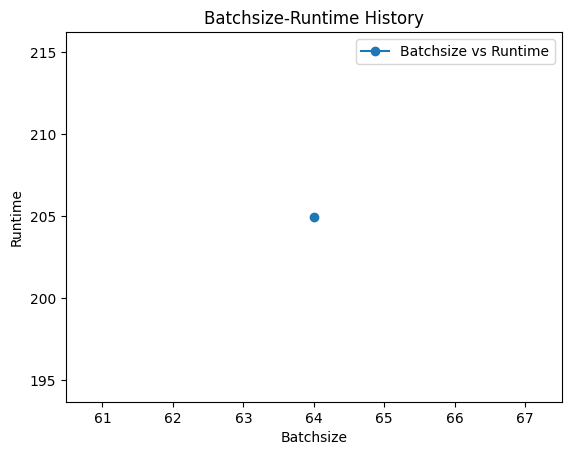

In [31]:
plot_batchsize_list = [64]
plot_save_fig_bool = False
plot_log_scale = False

plot_different_parameter_time_history = convert_to_list(data_time_history_total)
plot_batchsize_runtime_point = []
for plot_time_history in plot_different_parameter_time_history:
    plot_batchsize_runtime_point.append(plot_time_history[9])
plt.plot(plot_batchsize_list, plot_batchsize_runtime_point, marker='o', linestyle='-', label=f"Batchsize vs Runtime")
plt.xlabel("Batchsize")
if plot_log_scale is True:
    plt.ylabel("Log Runtime")
    plt.yscale('log')
else:
    plt.ylabel("Runtime")
plt.title("Batchsize-Runtime History")
plt.legend()
if plot_save_fig_bool is True:
    plt.savefig(f'Analysis_{current_dataset_name}_batchsize_runtime_{train_start_time}.png')
plt.show()

**Plot for Learning Rate-Accuracy curve.**

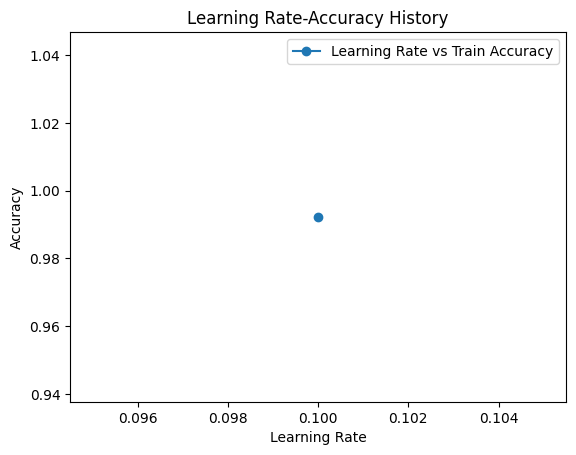

In [32]:
plot_lr_list = [0.1]
plot_save_fig_bool = False
plot_show_train_bool = True
plot_show_test_bool = False
plot_log_scale = False

plot_different_parameter_train_accuracy_history = convert_to_list(data_train_accuracy_history_total)
plot_different_parameter_test_accuracy_history = convert_to_list(data_test_accuracy_history_total)
plot_lr_accuracy_point_train = []
plot_lr_accuracy_point_test = []
if plot_show_train_bool is True:
    for plot_train_accuracy_history in plot_different_parameter_train_accuracy_history:
        plot_lr_accuracy_point_train.append(plot_train_accuracy_history[-1])
    plt.plot(plot_lr_list, plot_lr_accuracy_point_train, marker='o', linestyle='-', label=f"Learning Rate vs Train Accuracy")
if plot_show_test_bool is True:
    for plot_test_accuracy_history in plot_different_parameter_test_accuracy_history:
        plot_lr_accuracy_point_test.append(plot_test_accuracy_history[-1])
    plt.plot(plot_lr_list, plot_lr_accuracy_point_test, marker='x', linestyle='-', label=f"Learning Rate vs Test Accuracy")
plt.xlabel("Learning Rate")
if plot_log_scale is True:
    plt.ylabel("Log Accuracy")
    plt.yscale('log')
else:
    plt.ylabel("Accuracy")
plt.title("Learning Rate-Accuracy History")
plt.legend()
if plot_save_fig_bool is True:
    plt.savefig(f'Analysis_{current_dataset_name}_learning_rate_accuracy_{train_start_time}.png')
plt.show()